In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import numpy as np

# Загружаем данные

In [2]:
rides_path = 'data/rides_calc.csv'
weather_path = 'data/weather_processed.csv'
df_rides = pd.read_csv(rides_path)
df_weather = pd.read_csv(weather_path)

In [3]:
# поездки
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,cost
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0,1422.0,126.0
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0,1705.0,146.0
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0,2299.0,186.0
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0,1909.0,158.0
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0,1840.0,154.0


In [4]:
# погода
df_weather.head()


,datetime,temperature,precipitation_total,wind_gust,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-01 00:00:00,8.740245,0.1,48.60,21.638964,90.0,0.0
1,2023-04-01 01:00:00,9.040245,0.2,55.44,22.493519,74.0,0.0
2,2023-04-01 02:00:00,8.880245,0.3,55.80,22.264770,72.0,0.0
3,2023-04-01 03:00:00,8.690246,0.3,55.44,21.945240,77.0,0.0
4,2023-04-01 04:00:00,8.630245,0.3,48.96,22.424270,78.0,0.0


In [5]:
# Приведение столбцов времени к формату datetime
df_rides['start_date'] = pd.to_datetime(df_rides['start_date'])
df_rides['end_date'] = pd.to_datetime(df_rides['end_date'])
df_weather['datetime'] = pd.to_datetime(df_weather['datetime'])
df_rides.dtypes[['start_date', 'end_date']]

start_date    datetime64[ns]
end_date      datetime64[ns]
dtype: object

# Округляем время до часа

In [6]:
df_rides['hour'] = df_rides['start_date'].dt.floor('h')
df_weather['hour'] = df_weather['datetime'].dt.floor('h')

In [7]:
demand_hourly = (
    df_rides
    .groupby('hour')
    .size()
    .reset_index(name='demand')
)

weather_hourly = (
    df_weather
    .groupby('hour', as_index=False)[
        ['temperature', 'precipitation_total',
         'wind_speed', 'cloud_cover_total', 'sunshine_duration']
    ].mean()
)

df = demand_hourly.merge(weather_hourly, on='hour', how='left')

# Таблица с признаками

In [8]:
df.head()

,hour,demand,temperature,precipitation_total,wind_speed,cloud_cover_total,sunshine_duration
0,2023-04-22 09:00:00,20,13.850245,0.0,6.214563,71.0,16.969696
1,2023-04-22 10:00:00,42,16.230246,0.0,5.815978,88.0,6.666666
2,2023-04-22 11:00:00,29,17.080246,0.1,8.699793,94.0,3.030302
3,2023-04-22 12:00:00,46,18.130245,0.0,10.685391,22.2,46.545456
4,2023-04-22 13:00:00,47,18.370245,0.0,15.782622,38.0,36.969692


# Признаки и лаги

In [9]:
df = df.sort_values('hour').reset_index(drop=True)

df['hour_of_day'] = df['hour'].dt.hour           # час в сутках (0–23)
df['day_of_week'] = df['hour'].dt.dayofweek      # день недели, 0 = понедельник
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

# акция: понедельник, 6–9 час
df['is_promo'] = (
    (df['day_of_week'] == 0) &
    (df['hour_of_day'] >= 6) & (df['hour_of_day'] < 10)
).astype(int)

# идёт дождь, если осадки > 0
df['is_rain'] = (df['precipitation_total'] > 0).astype(int)

In [10]:
# Лаги спроса и скользящее среднее
df['demand_lag_1h'] = df['demand'].shift(1)
df['demand_lag_24h'] = df['demand'].shift(24)

# средний спрос за последние 24 часа (не включая текущий)
df['demand_mean_24h'] = (
    df['demand']
    .shift(1)
    .rolling(window=24, min_periods=1)
    .mean()
)

# убираем строки, где лаги ещё не посчитались
df = df.dropna().reset_index(drop=True)

Разбиение по времени

In [11]:
n = len(df)
train_end = int(0.7 * n)
valid_end = int(0.85 * n)

df_train = df.iloc[:train_end]
df_valid = df.iloc[train_end:valid_end]
df_test  = df.iloc[valid_end:]

Признаки и таргет

In [12]:
target_col = 'demand'

feature_cols_num = [
    'temperature', 'precipitation_total', 'wind_speed',
    'cloud_cover_total', 'sunshine_duration',
    'demand_lag_1h', 'demand_lag_24h', 'demand_mean_24h'
]

feature_cols_cat = [
    'hour_of_day', 'day_of_week', 'is_weekend', 'is_promo', 'is_rain'
]

X_train = df_train[feature_cols_num + feature_cols_cat]
y_train = df_train[target_col]

X_valid = df_valid[feature_cols_num + feature_cols_cat]
y_valid = df_valid[target_col]

X_test  = df_test[feature_cols_num + feature_cols_cat]
y_test  = df_test[target_col]


обучение модели

In [13]:
preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', feature_cols_num),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), feature_cols_cat),
    ]
)

model = LinearRegression()

pipe = Pipeline(steps=[
    ('preprocess', preprocess),
    ('model', model)
])

pipe.fit(X_train, y_train)

y_pred_valid = pipe.predict(X_valid)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
rmse_valid = np.sqrt(mse_valid)
r2_valid = r2_score(y_valid, y_pred_valid)
print('Valid RMSE:', rmse_valid)
print('Valid R2:', r2_valid)

y_pred_test = pipe.predict(X_test)
mse_test = mean_squared_error(y_test, y_pred_test)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_pred_test)
print('Test RMSE:', rmse_test)
print('Test R2:', r2_test)

Valid RMSE: 13.0427956671993
Valid R2: 0.838855329064592
Test RMSE: 13.535097535439787
Test R2: 0.8499145573488587


In [14]:
df['demand'].mean()

np.float64(40.21989528795812)

важность параметров

In [15]:
preprocess = pipe.named_steps['preprocess']
model = pipe.named_steps['model']

ohe = preprocess.named_transformers_['cat']
num_features = feature_cols_num
cat_features = list(ohe.get_feature_names_out(feature_cols_cat))

all_features = num_features + cat_features
len(all_features), model.coef_.shape

coef_df = (
    pd.DataFrame({
        'feature': all_features,
        'coef': model.coef_
    })
    .sort_values('coef', key=lambda s: s.abs(), ascending=False)
)

coef_df.head(20)


,feature,coef
26,hour_of_day_19,39.931497
25,hour_of_day_18,38.310805
27,hour_of_day_20,36.442893
23,hour_of_day_16,35.117190
24,hour_of_day_17,34.565996
22,hour_of_day_15,28.633666
21,hour_of_day_14,24.388446
28,hour_of_day_21,22.647930
29,hour_of_day_22,18.563949
20,hour_of_day_13,18.152601


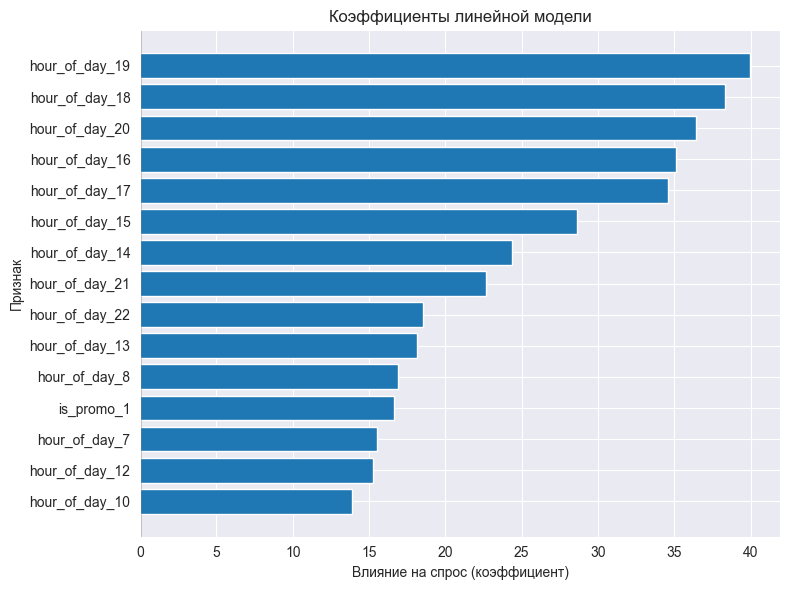

In [16]:
top_n = 15
plot_df = (
    coef_df
    .copy()
    .assign(abs_coef=lambda d: d['coef'].abs())
    .sort_values('abs_coef', ascending=False)
    .head(top_n)
)

plt.figure(figsize=(8, 6))
plt.barh(plot_df['feature'], plot_df['coef'])
plt.axvline(0, color='black', linewidth=1)
plt.gca().invert_yaxis()  # чтобы самый важный был сверху

plt.title('Коэффициенты линейной модели')
plt.xlabel('Влияние на спрос (коэффициент)')
plt.ylabel('Признак')
plt.tight_layout()
plt.show()


In [17]:
df_rides.head()

,id,start_date,end_date,start_location,start_district,end_location,end_district,distance,promo,duration,cost,hour
0,100340,2023-04-22 09:01:03,2023-04-22 09:24:45,Шевченко,Юго-Восточный,Майская,Октябрьский,4069.0,0,1422.0,126.0,2023-04-22 09:00:00
1,100341,2023-04-22 09:01:07,2023-04-22 09:29:32,Чехова,Заречный,Спортивная,Октябрьский,4515.0,0,1705.0,146.0,2023-04-22 09:00:00
2,100342,2023-04-22 09:04:27,2023-04-22 09:42:46,Буденного,Октябрьский,Суворова,Ленинский,4520.0,0,2299.0,186.0,2023-04-22 09:00:00
3,100343,2023-04-22 09:06:34,2023-04-22 09:38:23,Труда,Центральный,Рабочая,Северо-Западный,3881.0,0,1909.0,158.0,2023-04-22 09:00:00
4,100344,2023-04-22 09:09:27,2023-04-22 09:40:07,Первомайская,Северо-Западный,Юбилейная,Юго-Восточный,4029.0,0,1840.0,154.0,2023-04-22 09:00:00


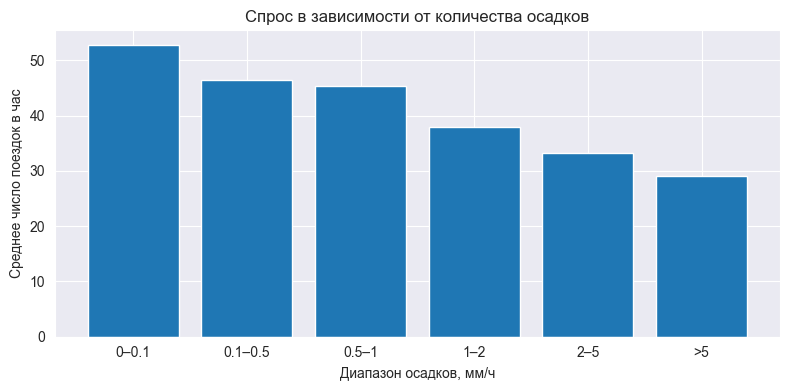

In [19]:
# смотрим максимум, чтобы последний бин был чуть выше
mask = (df['hour_of_day'] >= 6) & (df['hour_of_day'] <= 23)
df_day = df[mask].copy()
max_precip = df_day['precipitation_total'].max()
bins = [0.0, 0.1, 0.5, 1, 2, 5, max_precip + 1e-6]
labels = ['0–0.1', '0.1–0.5', '0.5–1', '1–2', '2–5', '>5']

df_day['precip_bin'] = pd.cut(
    df_day['precipitation_total'],
    bins=bins,
    labels=labels,
    include_lowest=True
)

demand_by_precip = (
    df_day.groupby('precip_bin', observed=True)['demand']
          .mean()
          .reset_index()
)

plt.figure(figsize=(8, 4))
plt.bar(demand_by_precip['precip_bin'].astype(str),
        demand_by_precip['demand'])
plt.xlabel('Диапазон осадков, мм/ч')
plt.ylabel('Среднее число поездок в час')
plt.title('Спрос в зависимости от количества осадков')
plt.tight_layout()
plt.show()
